# Sentiment Analysis with BERT

In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis.

You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

You'll learn how to:

*   Intuitively understand what BERT is
*   Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
*   Use Transfer Learning to build Sentiment Classifier using the Transformers 
*   Evaluate the model on test data
*   Predict sentiment on raw text

library by Hugging Face

Let's get started!

What is BERT?
BERT stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

*   Bidirectional - to understand the text you're looking you'll have to look back (at the previous words) and forward (at the next words)
*   Transformers -  The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
*   (Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Ex: Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

**Masked Language Modeling (Masked LM)**
The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's [mask] she [mask] -> That's what she said

**Next Sentence Prediction (NSP)**
Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

Input = [CLS] That's [mask] she [mask]. [SEP] Hahaha, nice! [SEP]

Label = IsNext

Input = [CLS] That's [mask] she [mask]. [SEP] Dwight, you ignorant [mask]! [SEP]

Label = NotNext

The training corpus was comprised of two entries: Toronto Book Corpus (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

Is This Thing Useful in Practice?
The BERT paper was released along with the source code and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

**Setup**

We'll need [the transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
!python -m pip install transformers

     |████████████████████████████████| 757kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 14.0MB/s 
     |████████████████████████████████| 1.1MB 31.3MB/s 
     |████████████████████████████████| 890kB 42.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=40c6a789e80eab1a6082675b391e2399f88c2f6f0a2dbb0b9ed7ba579df323e2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**Importing required libraries**

In [52]:
import transformers
import torch

import os
import copy
import numpy as np
import pandas as pd

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Data Exploration**

We'll load the Google Play app reviews dataset, that we've web scrapped and put together in the previous part:

In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 54.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 27.1MB/s]


In [5]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Great, no missing values in the score and review texts! 
Do we have class imbalance?

Text(0.5, 0, 'review score')

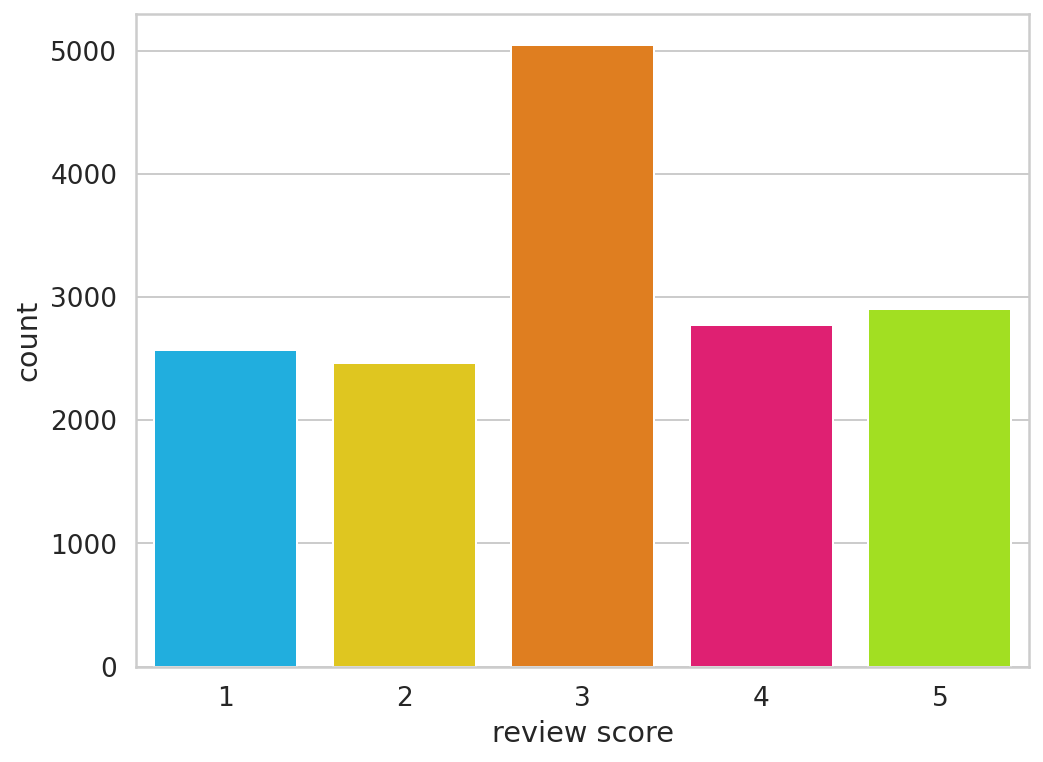

In [8]:
sns.countplot(df.score)
plt.xlabel('review score')

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [9]:
def to_sentiment(score):
  if score <= 2:
    return 0
  elif score ==3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

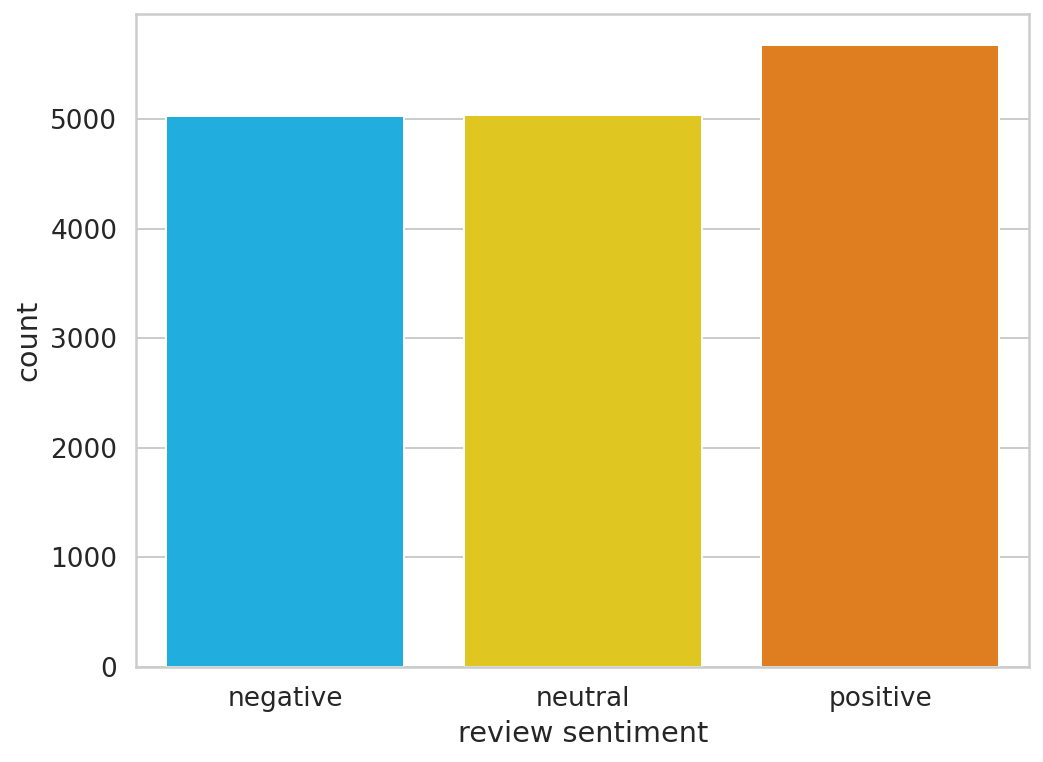

In [10]:
class_names = ['negative', 'neutral', 'positive']
ax=sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

It is mostly balanced!

**Data Preprocessing**

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

*   Add special tokens to separate sentences and do classification
*   Pass sequences of constant length (introduce padding)
*   Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

**Tokenizing**

Using the tokenizer provided by hugging face library which is pretrained using bert-base-uncased model.

Let us see how tokenizer works for few examples.

For each of the tokens their corresponding ids are sent as input to BERT.

In [11]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
sample_txt= "When was I last outside? I am stuck at home for 2 weeks."
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f' tokens: {tokens}')
print(f' token_ids: {token_ids}')
print(f' length of tokens: {len(tokens)}')
print(f' length of token_ids: {len(token_ids)}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
 tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
 token_ids: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]
 length of tokens: 15
 length of token_ids: 15


**Special Tokens**

In [13]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [14]:
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
# says whether a token is a padding token or not
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [16]:
# says whether a token is an unknown toekn that is not recorgnized by a tokenizer or not
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

**Creating an encode method (using encode_plus) which defines all the required steps for tokenization and data preprocessing the text.**

**tokenizer.encode vs tokenizer.encode_plus**

The main difference is stemming from the additional information that encode_plus is providing. 

encode():

Converts a string in a sequence of ids (integer), using the tokenizer and vocabulary. Same as doing self.convert_tokens_to_ids(self.tokenize(text)).

encode_plus():

Returns a dictionary containing the encoded sequence or sequence pair and additional information: the mask for sequence classification and the overflowing elements if a max_length is specified.

**encode_plus** (**text**: Union[str, List[str], List[int]], **text_pair**: Optional[Union[str, List[str], List[int]]] = None, **add_special_tokens**: bool = True, **max_length**: Optional[int] = None, stride: int = 0, truncation_strategy: str = 'longest_first', **pad_to_max_length**: bool = False, is_pretokenized: bool = False, **return_tensors**: Optional[str] = None, **return_token_type_ids**: Optional[bool] = None, **return_attention_mask**: Optional[bool] = None, **return_overflowing_tokens**: bool = False, return_special_tokens_mask: bool = False, return_offsets_mapping: bool = False, **kwargs) → transformers.tokenization_utils.BatchEncoding

**Returns a dictionary containing the encoded sequence or sequence pair and additional information: the mask for sequence classification and the overflowing elements if a max_length is specified.**

**Parameters:**


*   text (str, List[str] or List[int] (the later only for not-fast tokenizers)) – The first sequence to be encoded. This can be a string, a list of strings (tokenized string using the tokenize method) or a list of integers (tokenized string ids using the convert_tokens_to_ids method)

*   text_pair (str, List[str] or List[int], optional, defaults to None) – Optional second sequence to be encoded. This can be a string, a list of strings (tokenized string using the tokenize method) or a list of integers (tokenized string ids using the convert_tokens_to_ids method)

*   add_special_tokens (bool, optional, defaults to True) – If set to True, the sequences will be encoded with the special tokens relative to their model.

*   max_length (int, optional, defaults to None) – If set to a number, will limit the total sequence returned so that it has a maximum length. If there are overflowing tokens, those will be added to the returned dictionary You can set it to the maximal input size of the model with max_length = tokenizer.model_max_length.

*   stride (int, optional, defaults to 0) – If set to a number along with max_length, the overflowing tokens returned will contain some tokens from the main sequence returned. The value of this argument defines the number of additional tokens.

*   truncation_strategy (str, optional, defaults to longest_first) –
String selected in the following options:

  1.   ’longest_first’ (default) Iteratively reduce the inputs sequence until the input is under max_length starting from the longest one at each token (when there is a pair of input sequences)
  2.   ’only_first’: Only truncate the first sequence
  3.   ’only_second’: Only truncate the second sequence
  4.   ’do_not_truncate’: Does not truncate (raise an error if the input sequence is longer than max_length)

*   pad_to_max_length (bool, optional, defaults to False) –
If set to True, the returned sequences will be padded according to the model’s padding side and padding index, up to their max length. If no max length is specified, the padding is done up to the model’s max length. The tokenizer padding sides are handled by the class attribute padding_side which can be set to the following strings:

  1.   ’left’: pads on the left of the sequences
  2.   ’right’: pads on the right of the sequences
  3.   Defaults to False: no padding.

*   is_pretokenized (bool, defaults to False) – Set to True to indicate the input is already tokenized

*   return_tensors (str, optional, defaults to None) – Can be set to ‘tf’ or ‘pt’ to return respectively TensorFlow tf.constant or PyTorch torch.Tensor instead of a list of python integers.

*   return_token_type_ids (bool, optional, defaults to None) –

Whether to return token type IDs. If left to the default, will return the token type IDs according to the specific tokenizer’s default, defined by the return_outputs attribute.

[What are token type IDs?](https://huggingface.co/transformers/glossary.html#token-type-ids)

*   return_attention_mask (bool, optional, defaults to none) –

Whether to return the attention mask. If left to the default, will return the attention mask according to the specific tokenizer’s default, defined by the return_outputs attribute.

[What are attention masks?](https://huggingface.co/transformers/glossary.html#attention-mask)

*   return_overflowing_tokens (bool, optional, defaults to False) – Set to True *   to return overflowing token information (default False).

*   return_special_tokens_mask (bool, optional, defaults to False) – Set to True to return special tokens mask information (default False).

*   return_offsets_mapping (bool, optional, defaults to False) – Set to True to return (char_start, char_end) for each token (default False). If using Python’s tokenizer, this method will raise NotImplementedError. This one is only available on fast tokenizers inheriting from PreTrainedTokenizerFast.

**kwargs – passed to the self.tokenize() method

In [18]:
encoding=tokenizer.encode_plus(
                               sample_txt,
                               max_length=32,
                               add_special_tokens=True,
                               pad_to_max_length=True,
                               return_attention_mask=True,
                               return_token_type_ids=False,
                               return_tensors='pt',
                               truncation=True
                               )

In [19]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [20]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

Notice that encode_plus also inserted token_ids of special tokens which are needed along with the sequence to be sent as input to BERT.

In [21]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
print(len(encoding['input_ids'][0]));print(len(encoding['attention_mask'][0]))

32
32


**Choosing sequence length**

One simple way to choose the max_len for the sequences that we are going to encode is by looking at the distribution of length of the sequences and choose the threshold.

In [23]:
token_lens=[]
for text in df.content:
  tokens = tokenizer.encode(text,max_length=512,truncation=True)
  token_lens.append(len(tokens))

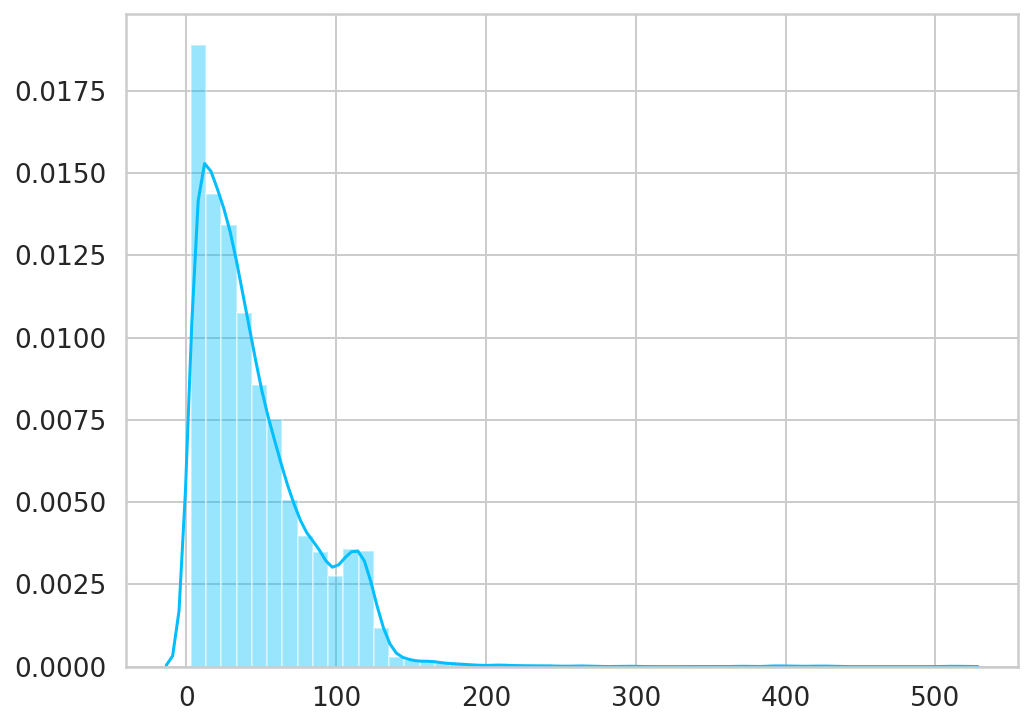

In [24]:
sns.distplot(token_lens)

Based on the distribution somewhere around 128 can be a good sequence length. 
The larger the sequence length the more time it takes for training. 

So, at the beginning its suggested to go on the aggressive side and give relatively shorter max_length which might clip some of the tokens. 

A prototype model can be trained faster by experimenting this way. Later we can go back and increase the sequence length to tune the model.

Create a method that takes input sequences and uses a built-in tokenizer which tokenzies and builds a dataset which is in the format supported by pytorch.

In [25]:
class GPReviewDataset(data.Dataset):
# constructor
  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

# To get the number of reviews
  def __len__(self):
    return (len(self.review))

# To get the review of an item
  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.target[item]

    encoding=tokenizer.encode_plus(
                                   review,
                                   max_length=self.max_len,
                                   add_special_tokens=True,
                                   pad_to_max_length=True,
                                   return_attention_mask=True,
                                   return_token_type_ids=False,
                                   return_tensors='pt',
                                   truncation=True
                                   )
    
    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target,dtype=torch.long)
    }

In [26]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [27]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [28]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 10

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  # creating an instance of the GPReviewDataset
  ds = GPReviewDataset(
                       review=df.content.to_numpy(),
                       target=df.sentiment.to_numpy(),
                       tokenizer=tokenizer,
                       max_len=max_len
                      )
  
  return data.DataLoader(
                         ds,
                         batch_size=batch_size,
                         num_workers=4)

In [30]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [31]:
# We can iterate over the data loader and have a look at the inputs. Instead of this we rather have a simpler way by looking at a batch
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [32]:
print(data['input_ids'].shape);print(data['attention_mask'].shape);print(data['targets'].shape);

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


For input_ids and attention_mask: 

Since BATCH_SIZE is 16, we have 16 reviews here and tokens len equal to 160. 

Similarly, for targets:

16 targets are the sentiment values that correspond to 16 reviews.

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use BertForSequenceClassification, BertForQuestionAnswering or something else.

But we’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model:

In [33]:
bert_model = BertModel.from_pretrained('bert-base-cased')
last_hidden_state, pooled_output = bert_model(
                                              input_ids=encoding['input_ids'],
                                              attention_mask=encoding['attention_mask']
)

The last_hidden_state is a sequence of hidden states (sequence of outputs of the hidden layer) of the last layer of the model. 

Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:

Inbuilt class in Huggingface library:

class BertPooler(nn.Module):

    def __init__(self, config):

        super().__init__()

        self.dense = nn.Linear(config.hidden_size, config.hidden_size)

        self.activation = nn.Tanh()

In [34]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). 

768 is the number of hidden units in the feedforward-networks. 

We can verify that by checking the config:

In [35]:
bert_model.config.hidden_size

768

You can think of the pooled_output as a summary of the content, according to 

You might try and do better. Let’s look at the shape of the output:

In [36]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model.

In [37]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. 

We use a dropout layer for some regularization and a fully-connected layer for our output. 

Note that we’re returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let’s create an instance and move it to the GPU

In [38]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We’ll move the example batch of our training data to the GPU:

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
torch.Size([16, 160])
torch.Size([16, 160])

torch.Size([16, 160])
torch.Size([16, 160])


torch.Size([16, 160])

To get the predicted probabilities from our trained model, we’ll apply the softmax function to the outputs:

In [40]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.3120, 0.1510, 0.5370],
        [0.5324, 0.1180, 0.3496],
        [0.6053, 0.1680, 0.2267],
        [0.3334, 0.1828, 0.4838],
        [0.4221, 0.1138, 0.4641],
        [0.3167, 0.2619, 0.4215],
        [0.3325, 0.1465, 0.5211],
        [0.2637, 0.1996, 0.5367],
        [0.4092, 0.1467, 0.4441],
        [0.3765, 0.2127, 0.4107],
        [0.5731, 0.0732, 0.3537],
        [0.4752, 0.1724, 0.3525],
        [0.3837, 0.1831, 0.4332],
        [0.3463, 0.2110, 0.4427]], device='cuda:0', grad_fn=<SoftmaxBackward>)

<b>Training</b>

To reproduce the training procedure from the BERT paper, we’ll use the AdamW optimizer provided by Hugging Face. 

It corrects weight decay. We’ll also use a linear scheduler with no warmup steps:

In [41]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
                                            optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps
                                           )
loss_fn = nn.CrossEntropyLoss().to(device)

Let’s continue with writing a helper function for training our model for one epoch:

In [42]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. 

The scheduler gets called every time a batch is fed to the model. 

We’re avoiding exploding gradients by clipping the gradients of the model using clipgrad_norm.

Let’s write another one that helps us evaluate the model on a given data loader:

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We’ll also store the training history:

In [76]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7421758737978494 accuracy 0.659233646178816
Val   loss 0.5847507223486901 accuracy 0.7636594663278272

Epoch 2/10
----------
Train loss 0.42195024685282473 accuracy 0.8373438712864301
Val   loss 0.5173206329345703 accuracy 0.8398983481575604

Epoch 3/10
----------
Train loss 0.23003165924639923 accuracy 0.9288688165972762
Val   loss 0.6139717100560665 accuracy 0.8640406607369759

Epoch 4/10
----------
Train loss 0.16254195039902664 accuracy 0.9540611107190742
Val   loss 0.729137781560421 accuracy 0.8678526048284626

Epoch 5/10
----------
Train loss 0.12220647735163805 accuracy 0.9669748077058783
Val   loss 0.8423944738507271 accuracy 0.8576874205844981

Epoch 6/10
----------
Train loss 0.08489101926709944 accuracy 0.9770658386846377
Val   loss 0.8022563126683235 accuracy 0.8703939008894537

Epoch 7/10
----------
Train loss 0.06562914470584882 accuracy 0.9807353044950956
Val   loss 0.848752261698246 accuracy 0.8716645489199493

Epoch 8/10
----------
Tr

Note that we’re storing the state of the best model, indicated by the highest validation accuracy.



In [48]:
# Loading a pretrained and saved model
os.chdir(r"/content/drive/My Drive/")
#!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

/content/drive/My Drive
Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/drive/My Drive/best_model_state.bin
433MB [00:06, 69.2MB/s]


We can look at the training vs validation accuracy:

In [50]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

You might try to fine-tune the parameters a bit more, but this will be good enough for us.

<b> Evaluation </b>

Calculating the accuracy on the test data:

In [51]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.883248730964467

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We’ll define a helper function to get the predictions from our model:

In [53]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities:

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let’s have a look at the classification report

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



Looks like it is really hard to classify neutral (3 stars) reviews. 

And I can tell you from experience, looking at many reviews, those are hard to classify.

We’ll continue with the confusion matrix:

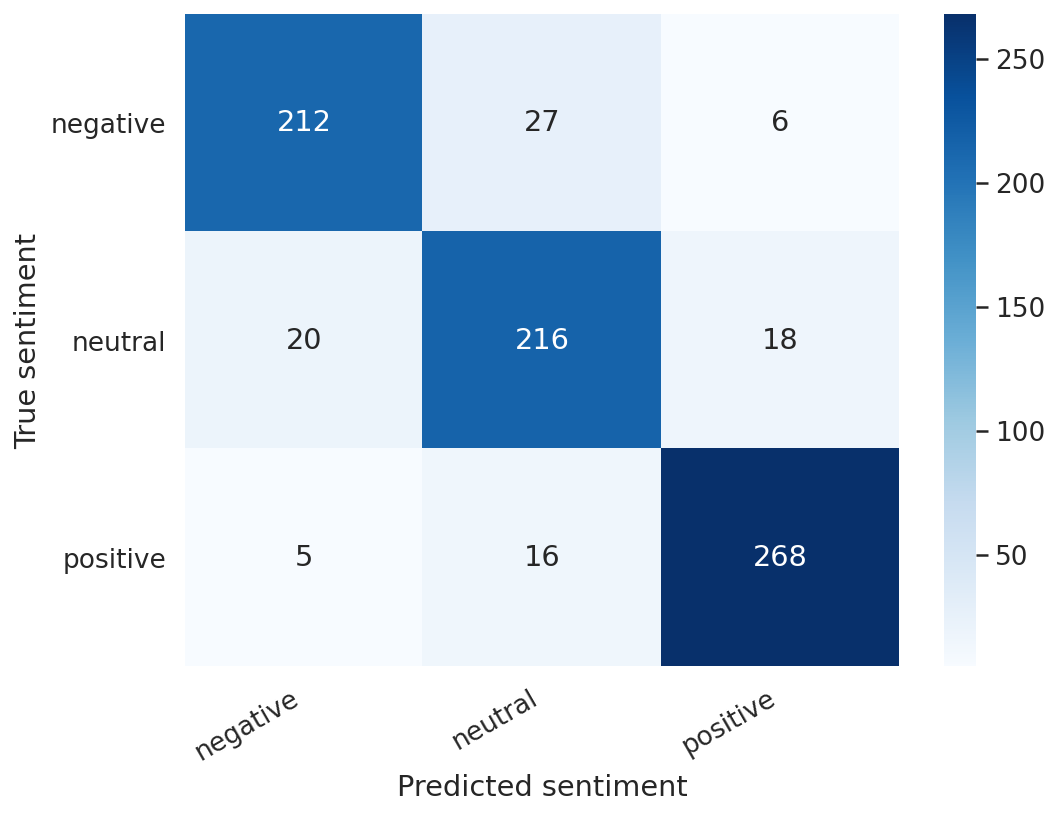

In [56]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model. But let’s have a look at an example from our test data:

In [59]:
from textwrap import wrap
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

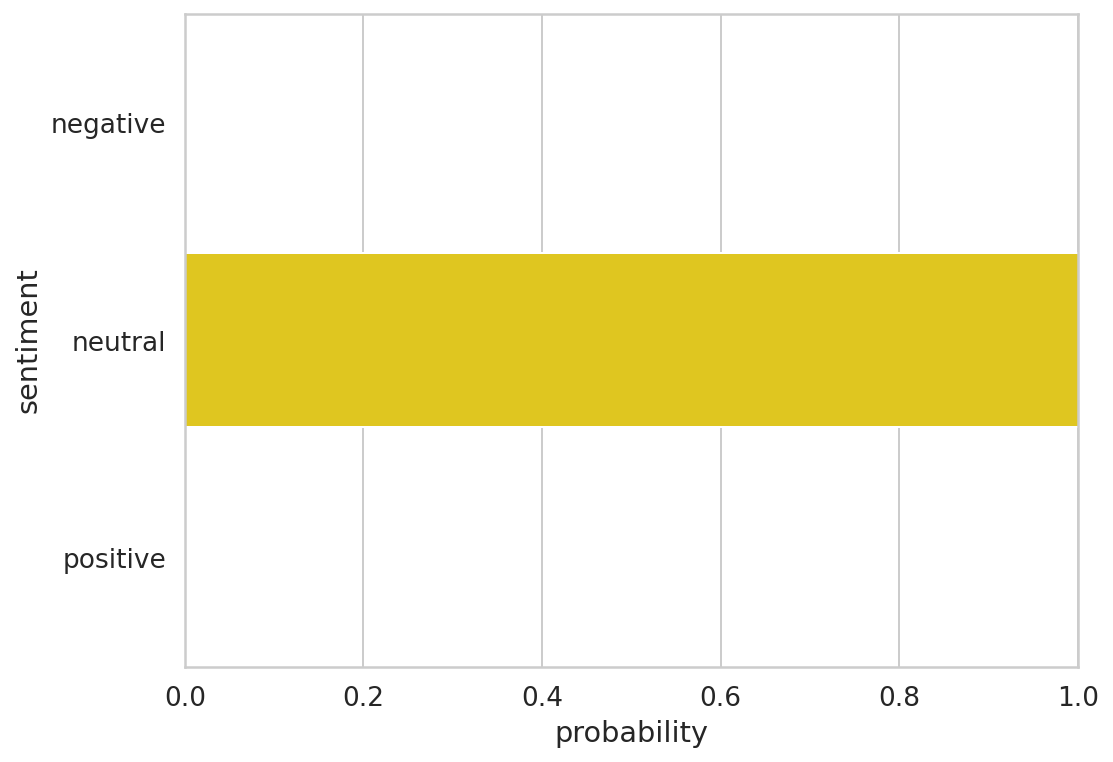

In [60]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

<b> Predicting on Raw Text </b>

Let’s use our model to predict the sentiment of some raw text:

In [61]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [62]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


Let’s get the predictions from our model:

In [63]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


<b> Summary: </b>

We built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

We have learned how to:

1.   Intuitively understand what BERT is
2.   Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
3.   Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
4.   Evaluate the model on test data
5.   Predict sentiment on raw text
